# Experiments with the greedy policy

In [10]:
from utils.card_engine import Card_Game, Card_Env, greedy_policy, move_to_card

import torch
import matplotlib
import matplotlib.pyplot as plt
import random

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [14]:
def plot_durations_rewards(durations, rewards, show_result=False):
    fig, ax = plt.subplots(2, 1)

    durations_t = torch.tensor(durations, dtype=torch.float)
    rewards_t = torch.tensor(rewards, dtype=torch.float)

    title = 'Result' if show_result else 'Training...'
    ax[0].set_title(f'{title} Duations each Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Duration')

    ax[1].set_title(f'{title} Rewards each Episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')

    ax[0].plot(durations_t.numpy())
    ax[1].plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0].plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[1].plot(means.numpy())

    fig.tight_layout()

    # plt.pause(0.001)  # pause a bit so that plots are updated
    # if is_ipython:
    #     if not show_result:
    #         display.clear_output(wait=True)
    #         display.display(fig)
    #     else:
    #         display.display(fig)


'''
simulate a game using policy against random agents
input:
- policy: game -> move
returns moves_played, culmulative_reward
'''
def simulate_game_random(policy, verbose=False, from_move=0):
    moves_played = 0
    culmulative_reward = 0

    active_player = from_move % 4
    if verbose:
        print(f"Starting new game as player {active_player} from turn {from_move}.")

    env = Card_Env()

    while env.game.current_player != active_player:
        move = env.game.sample_legal_move()
        env.game.play_card(move)

    for turn in range(13):
        move = policy(env.game)
        if not(move in env.game.get_legal_moves()):
            if verbose:
                print(f"Tried to play illegal move {move_to_card(move)}")
            return moves_played, culmulative_reward
        
        if verbose:
            print(f"Player plays {move_to_card(move)}")
        
        _, reward, terminated = env.step(move, None)

        moves_played += 1
        culmulative_reward += reward

        if terminated:
            return moves_played, culmulative_reward
    
    return moves_played, culmulative_reward


def simulate(policy, num_games, verbose=False):
    durations = []
    rewards = []

    simul_dist = [0 for _ in range(14)]

    for _ in range(num_games):
        moves_played, culmulative_reward = simulate_game_random(policy, verbose, from_move=random.randint(0,3))
        durations.append(moves_played)
        rewards.append(culmulative_reward)
        simul_dist[moves_played] += 1

    plot_durations_rewards(durations, rewards, show_result=True)
    print(f'Average simulated game duration: {sum(durations) / num_games}')
    print(f'Average reward per game: {sum(rewards) / num_games}')
    print(f"Distribution of simulated game lengths: {simul_dist}")


## Simulate games

Average simulated game duration: 13.0
Average reward per game: 3.8
Distribution of simulated game lengths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]


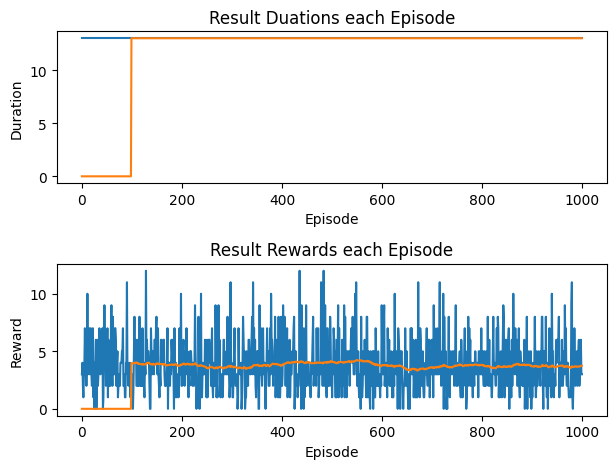

In [16]:
simulate(greedy_policy, 1000)